In [19]:
import numpy as np
from qutip import *
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy import integrate

from numpy import savetxt
from numpy import loadtxt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
from matplotlib import cm

## RCPs and their error curves

In [2]:
def get_unitary(Px,Py,tlist):  # get noiseless evolution unitary

    U0 = tensor(qeye(2))
    Px_f = IUS(tlist, Px) # interpolate function
    Py_f = IUS(tlist, Py) # interpolate function
    
    size_matrix = np.shape(U0)
    size_array = np.size(U0)
    
    def deriv(t,U):
        """
        Right hand side of the differential equations
          dU/dt = - i*H(t)*U
        """
        Udot = -1j * np.dot(H.full(), np.reshape(U, size_matrix))
        return np.reshape(Udot, size_array)
    
    def ode_qubit(tlist,Px_f,Py_f):
        U_list = []
        U_list.append(U0)

        U_step = np.reshape(U0, size_array)
        for k in range(len(tlist)-1):
            global H
            Px_k = float(Px_f((tlist[k]+tlist[k+1])/2))
            Py_k = float(Py_f((tlist[k]+tlist[k+1])/2))
            
            H =  0.5*Px_k*sigmax() + 0.5*Py_k*sigmay()
            
            sol = integrate.solve_ivp(deriv,(tlist[k],tlist[k+1]),(U_step), method='RK45')
            U_step = np.transpose(sol.y)[-1]
            U_list.append(np.reshape(U_step, size_matrix))

        Uf = Qobj(U_list[-1])
        return U_list
    
    U_list = ode_qubit(tlist,Px_f,Py_f)

    return U_list

def get_xyz(U,tlist): # get z error curve
    V1 = []
    xd = []
    yd = []
    zd = []
    for i in range(len(tlist)):
        V1.append(Qobj(U[i]).dag()*sigmaz()*Qobj(U[i]))
        xd.append(0.5*np.real(np.trace(sigmax()*V1[i])))
        yd.append(0.5*np.real(np.trace(sigmay()*V1[i])))
        zd.append(0.5*np.real(np.trace(sigmaz()*V1[i])))
    
    xd_f = IUS(tlist,xd)
    yd_f = IUS(tlist,yd)
    zd_f = IUS(tlist,zd)
    
    xdd_f = xd_f.derivative()
    ydd_f = yd_f.derivative()
    zdd_f = zd_f.derivative()
    
    def Length(x):
        return np.sqrt(xd_f(x)**2 + yd_f(x)**2 + zd_f(x)**2)
    L = integrate.quad(Length, 0, tlist[-1])[0]
    
    x = []
    y = []
    z = []
    for i in range(len(tlist)):
        x.append(xd_f.integral(0,tlist[i]))
        y.append(yd_f.integral(0,tlist[i]))
        z.append(zd_f.integral(0,tlist[i]))
    
    x = [(1/L) * j for j in x]
    y = [(1/L) * j for j in y]
    z = [(1/L) * j for j in z]
    
    return np.array(x),np.array(y),np.array(z)

def get_curve(Px,Py,tlist):
    U_list = get_unitary(Px,Py,tlist)
    x,y,z = get_xyz(U_list,tlist)
    return x,y,z

def curve_rot(x,y,phi):
    x1 = np.cos(phi)*x - np.sin(phi)*y
    y1 = np.sin(phi)*x + np.cos(phi)*y
    return x1,y1

In [3]:
# 1st order RCPs

P_1_pi = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_1_pi', delimiter=',')
P_1_7pi_4 = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_1_7pi_4', delimiter=',')
P_1_5pi_2 = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_1_5pi_2', delimiter=',')
P_1_2pi = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_1_2pi', delimiter=',')
tlist = np.linspace(0,50,501)

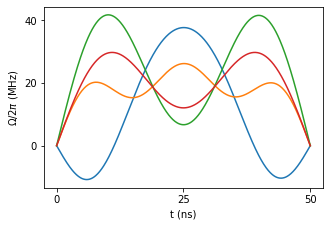

In [4]:
fig, ax = plt.subplots(figsize=(5,5*2/3))
ax.plot(tlist,1000 * P_1_pi/(2*np.pi))
ax.plot(tlist,1000 * P_1_7pi_4/(2*np.pi))
ax.plot(tlist,1000 * P_1_5pi_2/(2*np.pi))
ax.plot(tlist,1000 * P_1_2pi/(2*np.pi))
ax.set_xlabel('t (ns)')
ax.set_ylabel('$\Omega/2\pi$ (MHz)')
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xticks([0,25,50])

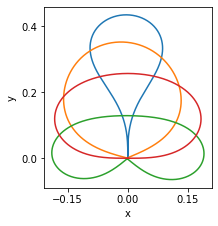

In [5]:
# z- error curves
x1,y1,z1 = get_curve(P_1_pi,np.zeros(len(tlist)),tlist)
x1,y1 = y1,z1
x2,y2,z2 = get_curve(P_1_7pi_4,np.zeros(len(tlist)),tlist)
x2,y2 = curve_rot(y2,z2,2*np.pi/5)
x3,y3,z3 = get_curve(P_1_5pi_2,np.zeros(len(tlist)),tlist)
x3,y3 = curve_rot(y3,z3,3*np.pi/4)
x4,y4,z4 = get_curve(P_1_2pi,np.zeros(len(tlist)),tlist)
x4,y4 = curve_rot(y4,z4,np.pi/2)

fig, ax = plt.subplots(figsize=(3,5*2/3))
ax.plot(x1,y1)
ax.plot(x2,y2)
ax.plot(x3,y3)
ax.plot(x4,y4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))

In [6]:
# extended RCPs

P_ex_pi = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_ex_pi', delimiter=',')
P_ex_9pi_4 = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_ex_9pi_4', delimiter=',')
P_ex_5pi_2 = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_ex_5pi_2', delimiter=',')
P_ex_2pi = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_ex_2pi', delimiter=',')
tlist = np.linspace(0,50,501)

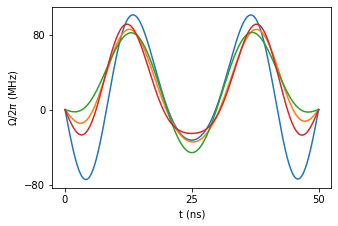

In [7]:
fig, ax = plt.subplots(figsize=(5,5*2/3))
ax.plot(tlist,1000 * P_ex_pi/(2*np.pi))
ax.plot(tlist,1000 * P_ex_9pi_4/(2*np.pi))
ax.plot(tlist,1000 * P_ex_5pi_2/(2*np.pi))
ax.plot(tlist,1000 * P_ex_2pi/(2*np.pi))
ax.set_xlabel('t (ns)')
ax.set_ylabel('$\Omega/2\pi$ (MHz)')
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xticks([0,25,50])

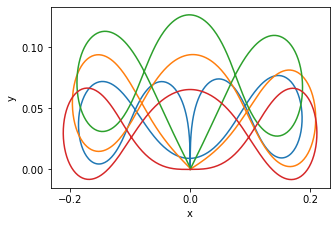

In [8]:
# z- error curves

x1,y1,z1 = get_curve(P_ex_pi,np.zeros(len(tlist)),tlist)
x1,y1 = y1,z1
x2,y2,z2 = get_curve(P_ex_9pi_4,np.zeros(len(tlist)),tlist)
x2,y2 = curve_rot(y2,z2,8*np.pi/5)
x3,y3,z3 = get_curve(P_ex_5pi_2,np.zeros(len(tlist)),tlist)
x3,y3 = curve_rot(y3,z3,7*np.pi/4)
x4,y4,z4 = get_curve(P_ex_2pi,np.zeros(len(tlist)),tlist)
x4,y4 = curve_rot(y4,z4,3*np.pi/2)

fig, ax = plt.subplots(figsize=(5,5*2/3))
ax.plot(x1,y1)
ax.plot(x2,y2)
ax.plot(x3,y3)
ax.plot(x4,y4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))

## Robust 1Q gate against detuning error

In [9]:
def gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal):
    delta_z = delta_list[0]
    delta_x = delta_list[1]
    delta_y = delta_list[2]
    
    Px = P_list[0]
    Py = P_list[1]
    Px_f = IUS(tlist, Px)
    Py_f = IUS(tlist, Py)
    
    U0 = tensor(qeye(2))
    size_matrix = np.shape(U0)
    size_array = np.size(U0)
    
    def deriv(t,U):
        """
        Right hand side of the differential equations
          dU/dt = - i*H(t)*U
        """
        Udot = -1j * np.dot(H.full(), np.reshape(U, size_matrix))
        return np.reshape(Udot, size_array)
    
    def ode_qubit(delta_z,delta_x,delta_y,tlist,Px_f,Py_f):
        U_list = []
        U_list.append(U0)

        U_step = np.reshape(U0, size_array)
        for k in range(len(tlist)-1):
            global H
            Px_k = float(Px_f((tlist[k]+tlist[k+1])/2))
            Py_k = float(Py_f((tlist[k]+tlist[k+1])/2))
            
            H =  delta_z*sigmaz() + delta_x*sigmax() + delta_y*sigmay()  \
            + 0.5*Px_k*sigmax() + 0.5*Py_k*sigmay()
            
            sol = integrate.solve_ivp(deriv,(tlist[k],tlist[k+1]),(U_step), method='RK45')
            U_step = np.transpose(sol.y)[-1]
            U_list.append(np.reshape(U_step, size_matrix))

        Uf = Qobj(U_list[-1])
        return Uf
    
    U_f = ode_qubit(delta_z,delta_x,delta_y,tlist,Px_f,Py_f)
    
    Uf = Qobj(Qobj(U_f).data.toarray().reshape((2,2)),dims=[[2],[2]])
    M = U_ideal.dag()*Uf
    F = 1/6 * (np.trace(M*M.dag()) + abs(np.trace(M))**2 )

    return np.real(F)

def get_P_cos(p_max,angle):
    T_cos = angle/(0.5*p_max)
    tlist_cos = np.linspace(0,T_cos,501)
    def f_cos(t,T_cos,p_max):
        return 0.5*p_max*(1+np.cos((t-T_cos/2)*(2*np.pi/T_cos)))

    P_cos = f_cos(tlist_cos,T_cos,p_max)
    return tlist_cos, P_cos

def u_rot_x(theta):
    return (-1j*0.5*(theta)*sigmax()).expm()

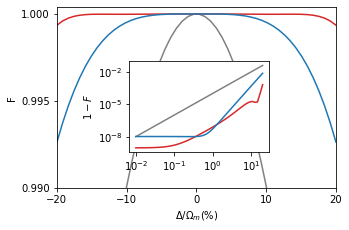

In [10]:
# X_pi gate

U_ideal = u_rot_x(np.pi)

# fidelity vs. Delta
M = 50  # number of data point

Omega_m_1 = max(np.abs(P_1_pi))
Delta_1 = np.linspace(-0.2*Omega_m_1,0.2*Omega_m_1,M)
Omega_m_ex = max(np.abs(P_ex_pi))
Delta_ex = np.linspace(-0.2*Omega_m_ex,0.2*Omega_m_ex,M)

tlist_cos, P_cos_pi = get_P_cos(Omega_m_1,np.pi)
Delta_cos = Delta_1

Fid_1 = np.zeros(M)
Fid_ex = np.zeros(M)
Fid_cos = np.zeros(M)

for i in range(M):
    delta_list = [0.5*Delta_1[i],0,0]
    P_list = [P_1_pi,np.zeros(len(P_1_pi))]
    Fid_1[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_ex[i],0,0]
    P_list = [P_ex_pi,np.zeros(len(P_ex_pi))]
    Fid_ex[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_1[i],0,0]
    P_list = [P_cos_pi,np.zeros(len(P_cos_pi))]
    Fid_cos[i] = gate_fidelity_qubit(delta_list,P_list,tlist_cos,U_ideal)


# fidelity vs. Delta in log scale
M_log = 50  # number of point
N_list = np.geomspace(0.0001,0.2,M_log)
Delta_1_log = N_list * Omega_m_1
Delta_ex_log = N_list * Omega_m_ex

Fid_1_log = np.zeros(M_log)
Fid_ex_log = np.zeros(M_log)
Fid_cos_log = np.zeros(M_log)

for i in range(M_log):
    delta_list = [0.5*Delta_1_log[i],0,0]
    P_list = [P_1_pi,np.zeros(len(P_1_pi))]
    Fid_1_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_ex_log[i],0,0]
    P_list = [P_ex_pi,np.zeros(len(P_ex_pi))]
    Fid_ex_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_1_log[i],0,0]
    P_list = [P_cos_pi,np.zeros(len(P_cos_pi))]
    Fid_cos_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist_cos,U_ideal)

    
# plot
fig, ax = plt.subplots(figsize=(5,5*2/3))

x = np.linspace(-20,20,M)
ax.plot( x, Fid_1,'C0',zorder=2)
ax.plot( x, Fid_ex,'C3',zorder=1)
ax.plot( x, Fid_cos,'grey',zorder=0)
ax.set_xlim(-20, 20)
ax.set_ylim(0.99, 1.0004)
ax.set_xticks([-20,-10,0,10,20])
ax.set_yticks([0.99,0.995,1])
ax.set_xlabel('$\Delta/\Omega_m (\%)$')
ax.set_ylabel('F')

ax_in = ax.inset_axes([0.26, 0.2, 0.5, 0.5])
x_in = 100 * N_list
ax_in.plot( x_in, [1 - i for i in Fid_1_log], 'C0', zorder=3)
ax_in.plot( x_in, [1 - i for i in Fid_ex_log], 'C3', zorder=2)
ax_in.plot( x_in, [1 - i for i in Fid_cos_log], 'grey', zorder=1)
ax_in.set_ylabel('$1-F$')
ax_in.set_yscale('log')
ax_in.set_xscale('log')
ax_in.set_yticks([10**(-8),10**(-5),10**(-2)])
ax_in.set_xticks([0.01,0.1,1,10])

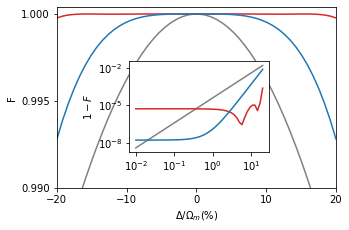

In [12]:
# X_pi/4 gate

U_ideal = u_rot_x(np.pi/4)

# fidelity vs. Delta
M = 50  # number of data point

Omega_m_1 = max(np.abs(P_1_7pi_4))
Delta_1 = np.linspace(-0.2*Omega_m_1,0.2*Omega_m_1,M)
Omega_m_ex = max(np.abs(P_ex_9pi_4))
Delta_ex = np.linspace(-0.2*Omega_m_ex,0.2*Omega_m_ex,M)

tlist_cos, P_cos_pi_4 = get_P_cos(Omega_m_1,np.pi/4)
Delta_cos = Delta_1

Fid_1 = np.zeros(M)
Fid_ex = np.zeros(M)
Fid_cos = np.zeros(M)

for i in range(M):
    delta_list = [0.5*Delta_1[i],0,0]
    P_list = [-P_1_7pi_4,np.zeros(len(P_1_7pi_4))]
    Fid_1[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_ex[i],0,0]
    P_list = [P_ex_9pi_4,np.zeros(len(P_ex_9pi_4))]
    Fid_ex[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_1[i],0,0]
    P_list = [P_cos_pi_4,np.zeros(len(P_cos_pi_4))]
    Fid_cos[i] = gate_fidelity_qubit(delta_list,P_list,tlist_cos,U_ideal)


# fidelity vs. Delta in log scale
M_log = 50  # number of point
N_list = np.geomspace(0.0001,0.2,M_log)
Delta_1_log = N_list * Omega_m_1
Delta_ex_log = N_list * Omega_m_ex

Fid_1_log = np.zeros(M_log)
Fid_ex_log = np.zeros(M_log)
Fid_cos_log = np.zeros(M_log)

for i in range(M_log):
    delta_list = [0.5*Delta_1_log[i],0,0]
    P_list = [-P_1_7pi_4,np.zeros(len(P_1_7pi_4))]
    Fid_1_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_ex_log[i],0,0]
    P_list = [P_ex_9pi_4,np.zeros(len(P_ex_9pi_4))]
    Fid_ex_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_1_log[i],0,0]
    P_list = [P_cos_pi_4,np.zeros(len(P_cos_pi_4))]
    Fid_cos_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist_cos,U_ideal)

    
# plot
fig, ax = plt.subplots(figsize=(5,5*2/3))

x = np.linspace(-20,20,M)
ax.plot( x, Fid_1,'C0',zorder=2)
ax.plot( x, Fid_ex,'C3',zorder=1)
ax.plot( x, Fid_cos,'grey',zorder=0)
ax.set_xlim(-20, 20)
ax.set_ylim(0.99, 1.0004)
ax.set_xticks([-20,-10,0,10,20])
ax.set_yticks([0.99,0.995,1])
ax.set_xlabel('$\Delta/\Omega_m (\%)$')
ax.set_ylabel('F')

ax_in = ax.inset_axes([0.26, 0.2, 0.5, 0.5])
x_in = 100 * N_list
ax_in.plot( x_in, [1 - i for i in Fid_1_log], 'C0', zorder=3)
ax_in.plot( x_in, [1 - i for i in Fid_ex_log], 'C3', zorder=2)
ax_in.plot( x_in, [1 - i for i in Fid_cos_log], 'grey', zorder=1)
ax_in.set_ylabel('$1-F$')
ax_in.set_yscale('log')
ax_in.set_xscale('log')
ax_in.set_yticks([10**(-8),10**(-5),10**(-2)])
ax_in.set_xticks([0.01,0.1,1,10])

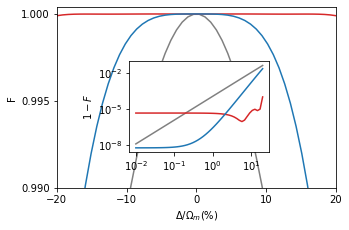

In [13]:
# X_pi/2 gate

U_ideal = u_rot_x(np.pi/2)

# fidelity vs. Delta
M = 50  # number of data point

Omega_m_1 = max(np.abs(P_1_5pi_2))
Delta_1 = np.linspace(-0.2*Omega_m_1,0.2*Omega_m_1,M)
Omega_m_ex = max(np.abs(P_ex_5pi_2))
Delta_ex = np.linspace(-0.2*Omega_m_ex,0.2*Omega_m_ex,M)

tlist_cos, P_cos_pi_2 = get_P_cos(Omega_m_1,np.pi/2)
Delta_cos = Delta_1

Fid_1 = np.zeros(M)
Fid_ex = np.zeros(M)
Fid_cos = np.zeros(M)

for i in range(M):
    delta_list = [0.5*Delta_1[i],0,0]
    P_list = [P_1_5pi_2,np.zeros(len(P_1_5pi_2))]
    Fid_1[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_ex[i],0,0]
    P_list = [P_ex_5pi_2,np.zeros(len(P_ex_5pi_2))]
    Fid_ex[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_1[i],0,0]
    P_list = [P_cos_pi_2,np.zeros(len(P_cos_pi_2))]
    Fid_cos[i] = gate_fidelity_qubit(delta_list,P_list,tlist_cos,U_ideal)


# fidelity vs. Delta in log scale
M_log = 50  # number of point
N_list = np.geomspace(0.0001,0.2,M_log)
Delta_1_log = N_list * Omega_m_1
Delta_ex_log = N_list * Omega_m_ex

Fid_1_log = np.zeros(M_log)
Fid_ex_log = np.zeros(M_log)
Fid_cos_log = np.zeros(M_log)

for i in range(M_log):
    delta_list = [0.5*Delta_1_log[i],0,0]
    P_list = [P_1_5pi_2,np.zeros(len(P_1_5pi_2))]
    Fid_1_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_ex_log[i],0,0]
    P_list = [P_ex_5pi_2,np.zeros(len(P_ex_5pi_2))]
    Fid_ex_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_1_log[i],0,0]
    P_list = [P_cos_pi_2,np.zeros(len(P_cos_pi_2))]
    Fid_cos_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist_cos,U_ideal)

    
# plot
fig, ax = plt.subplots(figsize=(5,5*2/3))

x = np.linspace(-20,20,M)
ax.plot( x, Fid_1,'C0',zorder=2)
ax.plot( x, Fid_ex,'C3',zorder=1)
ax.plot( x, Fid_cos,'grey',zorder=0)
ax.set_xlim(-20, 20)
ax.set_ylim(0.99, 1.0004)
ax.set_xticks([-20,-10,0,10,20])
ax.set_yticks([0.99,0.995,1])
ax.set_xlabel('$\Delta/\Omega_m (\%)$')
ax.set_ylabel('F')

ax_in = ax.inset_axes([0.26, 0.2, 0.5, 0.5])
x_in = 100 * N_list
ax_in.plot( x_in, [1 - i for i in Fid_1_log], 'C0', zorder=3)
ax_in.plot( x_in, [1 - i for i in Fid_ex_log], 'C3', zorder=2)
ax_in.plot( x_in, [1 - i for i in Fid_cos_log], 'grey', zorder=1)
ax_in.set_ylabel('$1-F$')
ax_in.set_yscale('log')
ax_in.set_xscale('log')
ax_in.set_yticks([10**(-8),10**(-5),10**(-2)])
ax_in.set_xticks([0.01,0.1,1,10])

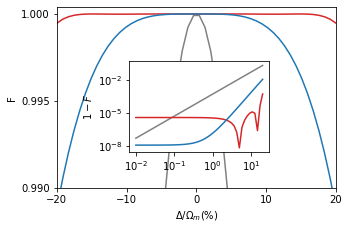

In [14]:
# X_2pi gate

U_ideal = u_rot_x(2*np.pi)

# fidelity vs. Delta
M = 50  # number of data point

Omega_m_1 = max(np.abs(P_1_2pi))
Delta_1 = np.linspace(-0.2*Omega_m_1,0.2*Omega_m_1,M)
Omega_m_ex = max(np.abs(P_ex_2pi))
Delta_ex = np.linspace(-0.2*Omega_m_ex,0.2*Omega_m_ex,M)

tlist_cos, P_cos_2pi = get_P_cos(Omega_m_1,2*np.pi)
Delta_cos = Delta_1

Fid_1 = np.zeros(M)
Fid_ex = np.zeros(M)
Fid_cos = np.zeros(M)

for i in range(M):
    delta_list = [0.5*Delta_1[i],0,0]
    P_list = [P_1_2pi,np.zeros(len(P_1_2pi))]
    Fid_1[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_ex[i],0,0]
    P_list = [P_ex_2pi,np.zeros(len(P_ex_2pi))]
    Fid_ex[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_1[i],0,0]
    P_list = [P_cos_2pi,np.zeros(len(P_cos_2pi))]
    Fid_cos[i] = gate_fidelity_qubit(delta_list,P_list,tlist_cos,U_ideal)


# fidelity vs. Delta in log scale
M_log = 50  # number of point
N_list = np.geomspace(0.0001,0.2,M_log)
Delta_1_log = N_list * Omega_m_1
Delta_ex_log = N_list * Omega_m_ex

Fid_1_log = np.zeros(M_log)
Fid_ex_log = np.zeros(M_log)
Fid_cos_log = np.zeros(M_log)

for i in range(M_log):
    delta_list = [0.5*Delta_1_log[i],0,0]
    P_list = [P_1_2pi,np.zeros(len(P_1_2pi))]
    Fid_1_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_ex_log[i],0,0]
    P_list = [P_ex_2pi,np.zeros(len(P_ex_2pi))]
    Fid_ex_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0.5*Delta_1_log[i],0,0]
    P_list = [P_cos_2pi,np.zeros(len(P_cos_2pi))]
    Fid_cos_log[i] = gate_fidelity_qubit(delta_list,P_list,tlist_cos,U_ideal)

    
# plot
fig, ax = plt.subplots(figsize=(5,5*2/3))

x = np.linspace(-20,20,M)
ax.plot( x, Fid_1,'C0',zorder=2)
ax.plot( x, Fid_ex,'C3',zorder=1)
ax.plot( x, Fid_cos,'grey',zorder=0)
ax.set_xlim(-20, 20)
ax.set_ylim(0.99, 1.0004)
ax.set_xticks([-20,-10,0,10,20])
ax.set_yticks([0.99,0.995,1])
ax.set_xlabel('$\Delta/\Omega_m (\%)$')
ax.set_ylabel('F')

ax_in = ax.inset_axes([0.26, 0.2, 0.5, 0.5])
x_in = 100 * N_list
ax_in.plot( x_in, [1 - i for i in Fid_1_log], 'C0', zorder=3)
ax_in.plot( x_in, [1 - i for i in Fid_ex_log], 'C3', zorder=2)
ax_in.plot( x_in, [1 - i for i in Fid_cos_log], 'grey', zorder=1)
ax_in.set_ylabel('$1-F$')
ax_in.set_yscale('log')
ax_in.set_xscale('log')
ax_in.set_yticks([10**(-8),10**(-5),10**(-2)])
ax_in.set_xticks([0.01,0.1,1,10])

## Robust gate against x, y, z error

Text(0, 0.5, '$\\Phi(t)$ (rad)')

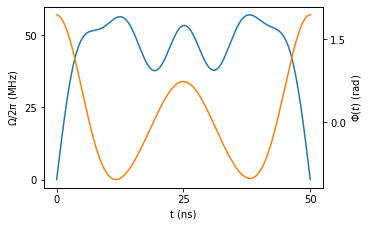

In [23]:
Omega_3pi_2 = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_1_3pi_2_all_Omega', delimiter=',')
Phi_3pi_2 = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_1_3pi_2_all_Phi', delimiter=',')
tlist = np.linspace(0,50,501)

fig, ax = plt.subplots(figsize=(5,5*2/3))
ax.plot(tlist,1000 * Omega_3pi_2 /(2*np.pi))
ax.set_xlabel('t (ns)')
ax.set_ylabel('$\Omega/2\pi$ (MHz)')
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xticks([0,25,50])

ax2 = ax.twinx()
ax2.plot(tlist,Phi_3pi_2,'C1')
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_ylabel('$\Phi(t)$ (rad)')

Text(0, 0.5, 'F')

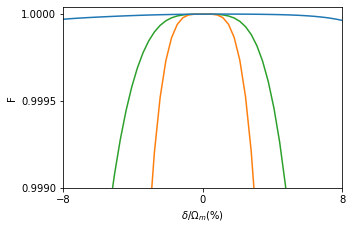

In [24]:
# X_3pi_2 gate

U_ideal = u_rot_x(3*np.pi/2)

# fidelity vs. Delta
M = 50  # number of data point

Omega_m = max(np.abs(Omega_3pi_2))
delta_z = np.linspace(-0.08*Omega_m,0.08*Omega_m,M)
delta_x = np.linspace(-0.08*Omega_m,0.08*Omega_m,M)
delta_y = np.linspace(-0.08*Omega_m,0.08*Omega_m,M)

Fid_z = np.zeros(M)
Fid_x = np.zeros(M)
Fid_y = np.zeros(M)

for i in range(M):
    delta_list = [delta_z[i],0,0]
    P_list = [Omega_3pi_2*np.cos(Phi_3pi_2),Omega_3pi_2*np.sin(Phi_3pi_2)]
    Fid_z[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0,delta_x[i],0]
    P_list = [Omega_3pi_2*np.cos(Phi_3pi_2),Omega_3pi_2*np.sin(Phi_3pi_2)]
    Fid_x[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0,0,delta_y[i]]
    P_list = [Omega_3pi_2*np.cos(Phi_3pi_2),Omega_3pi_2*np.sin(Phi_3pi_2)]
    Fid_y[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
# plot
fig, ax = plt.subplots(figsize=(5,5*2/3))

x = np.linspace(-8,8,M)
ax.plot( x, Fid_z,'C0',zorder=2)
ax.plot( x, Fid_x,'C1',zorder=1)
ax.plot( x, Fid_y,'C2',zorder=0)
ax.set_xlim(-8, 8)
ax.set_ylim(0.999, 1.00004)
ax.set_xticks([-8,0,8])
ax.set_yticks([0.999,0.9995,1])
ax.set_xlabel('$\delta/\Omega_m (\%)$')
ax.set_ylabel('F')

In [17]:
# robustness against longitudinal and transverse noise

U_ideal = u_rot_x(3*np.pi/2)

# fidelity vs. Delta and epsilon

Omega_m = max(np.abs(Omega_3pi_2))
Delta = np.linspace(-0.30*Omega_m,0.30*Omega_m,40)
epsilon = np.linspace(-0.16*Omega_m,0.16*Omega_m,20)

F_list = np.zeros((len(epsilon),len(Delta)))

for i in range(len(epsilon)):
    for j in range(len(Delta)):
        delta_list = [0.5*Delta[j],0.5*epsilon[i],0.5*epsilon[i]]
        P_list = [Omega_3pi_2*np.cos(Phi_3pi_2),Omega_3pi_2*np.sin(Phi_3pi_2)]
        F_list[i][j] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)

Text(0.5, 0, 'F')

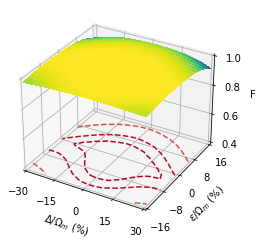

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.linspace(-30,30,40)
y = np.linspace(-16,16,20)
X,Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, F_list, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',norm=colors.Normalize(vmin=0.9, vmax=1),antialiased=False);
ax.invert_xaxis()
ax.set_ylim(-16, 16)
ax.set_xlim(-30, 30)
ax.set_zlim(0.40, 1.0)
ax.set_xticks([-30,-15,0,15,30])
ax.set_yticks([-16,-8,0,8,16])
ax.set_zticks([0.4,0.6,0.8,1.0])

levels = [0.9,0.99,0.999,0.9999]
CS1 = ax.contour(X, Y, F_list, levels, zdir='z', offset=0.4, cmap=cm.coolwarm, linestyles='dashed')

ax.set_xlabel('$\Delta/\Omega_m$ (%)')
ax.set_ylabel('$\epsilon/\Omega_m$ (%)')
ax.set_zlabel('F')

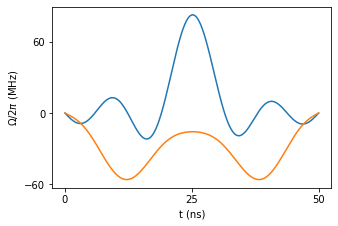

In [21]:
# X_pi gate

Omega_x_pi = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_1_pi_all_Omega_x', delimiter=',')
Omega_y_pi = loadtxt(r"C:\Users\Quantum\Desktop\RCP_data\%s.csv" %'RCP_1_pi_all_Omega_y', delimiter=',')
tlist = np.linspace(0,50,501)

fig, ax = plt.subplots(figsize=(5,5*2/3))
ax.plot(tlist,1000 * Omega_x_pi /(2*np.pi))
ax.plot(tlist,1000 * Omega_y_pi /(2*np.pi))
ax.set_xlabel('t (ns)')
ax.set_ylabel('$\Omega/2\pi$ (MHz)')
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xticks([0,25,50])

Text(0, 0.5, 'F')

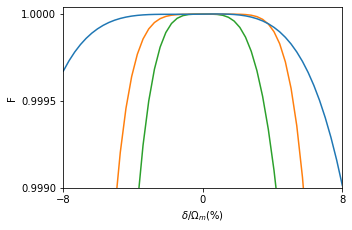

In [25]:
U_ideal = u_rot_x(np.pi)

# fidelity vs. Delta
M = 50  # number of data point

Omega_m = max(np.abs(Omega_x_pi))
delta_z = np.linspace(-0.08*Omega_m,0.08*Omega_m,M)
delta_x = np.linspace(-0.08*Omega_m,0.08*Omega_m,M)
delta_y = np.linspace(-0.08*Omega_m,0.08*Omega_m,M)

Fid_z = np.zeros(M)
Fid_x = np.zeros(M)
Fid_y = np.zeros(M)

for i in range(M):
    delta_list = [delta_z[i],0,0]
    P_list = [Omega_x_pi,Omega_y_pi]
    Fid_z[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0,delta_x[i],0]
    P_list = [Omega_x_pi,Omega_y_pi]
    Fid_x[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
    delta_list = [0,0,delta_y[i]]
    P_list = [Omega_x_pi,Omega_y_pi]
    Fid_y[i] = gate_fidelity_qubit(delta_list,P_list,tlist,U_ideal)
    
# plot
fig, ax = plt.subplots(figsize=(5,5*2/3))

x = np.linspace(-8,8,M)
ax.plot( x, Fid_z,'C0',zorder=2)
ax.plot( x, Fid_x,'C1',zorder=1)
ax.plot( x, Fid_y,'C2',zorder=0)
ax.set_xlim(-8, 8)
ax.set_ylim(0.999, 1.00004)
ax.set_xticks([-8,0,8])
ax.set_yticks([0.999,0.9995,1])
ax.set_xlabel('$\delta/\Omega_m (\%)$')
ax.set_ylabel('F')